# General Introduction

Since 2010, I have been working on the development of an open source toolkit for supporting decision-making under deep uncertainty. This toolkit is known as the exploratory modeling workbench. The motivation for this name is that in my opinion all model-based deep uncertainty approaches are forms of exploratory modeling as first introduced by [Bankes (1993)](http://pubsonline.informs.org/doi/pdf/10.1287/opre.41.3.435). The design of the workbench has undergone various changes over time, but it has started to stabilize in the fall of 2016. In the summer 0f 2017, I published a paper detailing the workbench [(Kwakkel, 2017)](http://www.sciencedirect.com/science/article/pii/S1364815217301251). There is an in depth example in the paper, but for the documentation I want to provide a more tutorial style description of the functionality of the workbench.

As a starting point, I will use the Direct Policy Search example that is available for Rhodium [(Quinn et al 2017)](http://www.sciencedirect.com/science/article/pii/S1364815216302250). A quick note on terminology is in order here. I have a background in transport modeling. Here we often use discrete event simulation models. These are intrinsically stochastic models. It is standard practice to run these models several times and take descriptive statistics over the set of runs. In discrete event simulation, and also in the context of agent based modeling, this is known as running replications. The workbench adopts this terminology and draws a sharp distinction between designing experiments over a set of deeply uncertain factors, and performing replications of this experiment to cope with stochastic uncertainty. 

In [1]:
import math

# more or less default imports when using
# the workbench
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.optimize import brentq


def get_antropogenic_release(xt, c1, c2, r1, r2, w1):
    """

    Parameters
    ----------
    xt : float
         polution in lake at time t
    c1 : float
         center rbf 1
    c2 : float
         center rbf 2
    r1 : float
         ratius rbf 1
    r2 : float
         ratius rbf 2
    w1 : float
         weight of rbf 1

    Returns
    -------
    float

    note:: w2 = 1 - w1

    """

    rule = w1 * (abs(xt - c1) / r1) ** 3 + (1 - w1) * (abs(xt - c2) / r2) ** 3
    at1 = max(rule, 0.01)
    at = min(at1, 0.1)

    return at


def lake_model(
    b=0.42,
    q=2.0,
    mean=0.02,
    stdev=0.001,
    delta=0.98,
    alpha=0.4,
    nsamples=100,
    myears=100,
    c1=0.25,
    c2=0.25,
    r1=0.5,
    r2=0.5,
    w1=0.5,
    seed=None,
):
    """runs the lake model for nsamples stochastic realisation using
    specified random seed.

    Parameters
    ----------
    b : float
        decay rate for P in lake (0.42 = irreversible)
    q : float
        recycling exponent
    mean : float
            mean of natural inflows
    stdev : float
            standard deviation of natural inflows
    delta : float
            future utility discount rate
    alpha : float
            utility from pollution
    nsamples : int, optional
    myears : int, optional
    c1 : float
    c2 : float
    r1 : float
    r2 : float
    w1 : float
    seed : int, optional
           seed for the random number generator

    Returns
    -------
    tuple

    """
    np.random.seed(seed)
    Pcrit = brentq(lambda x: x**q / (1 + x**q) - b * x, 0.01, 1.5)

    X = np.zeros((myears,))
    average_daily_P = np.zeros((myears,))
    reliability = 0.0
    inertia = 0
    utility = 0

    for _ in range(nsamples):
        X[0] = 0.0
        decision = 0.1

        decisions = np.zeros(
            myears,
        )
        decisions[0] = decision

        natural_inflows = np.random.lognormal(
            math.log(mean**2 / math.sqrt(stdev**2 + mean**2)),
            math.sqrt(math.log(1.0 + stdev**2 / mean**2)),
            size=myears,
        )

        for t in range(1, myears):

            # here we use the decision rule
            decision = get_antropogenic_release(X[t - 1], c1, c2, r1, r2, w1)
            decisions[t] = decision

            X[t] = (
                (1 - b) * X[t - 1]
                + X[t - 1] ** q / (1 + X[t - 1] ** q)
                + decision
                + natural_inflows[t - 1]
            )
            average_daily_P[t] += X[t] / nsamples

        reliability += np.sum(X < Pcrit) / (nsamples * myears)
        inertia += np.sum(np.absolute(np.diff(decisions) < 0.02)) / (nsamples * myears)
        utility += (
            np.sum(alpha * decisions * np.power(delta, np.arange(myears))) / nsamples
        )
    max_P = np.max(average_daily_P)
    return max_P, utility, inertia, reliability

## Connecting a python function to the workbench

Now we are ready to connect this model to the workbench. We have to specify the uncertainties, the outcomes, and the policy levers. For the uncertainties and the levers, we can use real valued parameters, integer valued parameters, and categorical parameters. For outcomes, we can use either scalar, single valued outcomes or time series outcomes. For convenience, we can also explicitly control constants in case we want to have them set to a value different from their default value. 


In [2]:
from ema_workbench import RealParameter, ScalarOutcome, Constant, Model
from dps_lake_model import lake_model

model = Model("lakeproblem", function=lake_model)

# specify uncertainties
model.uncertainties = [
    RealParameter("b", 0.1, 0.45),
    RealParameter("q", 2.0, 4.5),
    RealParameter("mean", 0.01, 0.05),
    RealParameter("stdev", 0.001, 0.005),
    RealParameter("delta", 0.93, 0.99),
]

# set levers
model.levers = [
    RealParameter("c1", -2, 2),
    RealParameter("c2", -2, 2),
    RealParameter("r1", 0, 2),
    RealParameter("r2", 0, 2),
    RealParameter("w1", 0, 1),
]

# specify outcomes
model.outcomes = [
    ScalarOutcome("max_P"),
    ScalarOutcome("utility"),
    ScalarOutcome("inertia"),
    ScalarOutcome("reliability"),
]

# override some of the defaults of the model
model.constants = [
    Constant("alpha", 0.41),
    Constant("nsamples", 150),
    Constant("myears", 100),
]

## Performing experiments

Now that we have specified the model with the workbench, we are ready to perform experiments on it. We can use evaluators to distribute these experiments either over multiple cores on a single machine, or over a cluster using `ipyparallel`. Using any parallelization is an advanced topic, in particular if you are on a windows machine. The code as presented here will run fine in parallel on a mac or Linux machine. If you are trying to run this in parallel using multiprocessing on a windows machine, from within a jupyter notebook, it won't work. The solution is to move the `lake_model` and `get_antropogenic_release` to a separate python module and import the lake model function into the notebook.  

Another common practice when working with the exploratory modeling workbench is to turn on the logging functionality that it provides. This will report on the progress of the experiments, as well as provide more insight into what is happening in particular in case of errors. 

If we want to perform experiments on the model we have just defined, we can use the perform_experiments method on the evaluator, or the stand alone perform_experiments function. We can perform experiments over the uncertainties and/or over the levers. Any given parameterization of the levers is known as a policy, while any given parametrization over the uncertainties is known as a scenario. Any policy is evaluated over each of the scenarios. So if we want to use 100 scenarios and 10 policies, this means that we will end up performing 100 * 10 = 1000 experiments. By default, the workbench uses Latin hypercube sampling for both sampling over levers and sampling over uncertainties. However, the workbench also offers support for full factorial, partial factorial, and Monte Carlo sampling, as well as wrappers for the various sampling schemes provided by [SALib](http://salib.readthedocs.io). 

The ema_workbench offers support for parallelization of the execution of the experiments using either the [multiprocessing](https://docs.python.org/3/library/multiprocessing.html) or [ipyparallel](http://ipyparallel.readthedocs.io/en/latest/). There are various OS specific concerns you have to keep in mind when using either of these libraries. Please have a look at the documentation of these libraries, before using them.


In [3]:
from ema_workbench import MultiprocessingEvaluator, ema_logging, perform_experiments

ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(scenarios=1000, policies=10)

[MainProcess/INFO] pool started with 12 workers
[MainProcess/INFO] performing 1000 scenarios * 10 policies * 1 model(s) = 10000 experiments
100%|████████████████████████████████████| 10000/10000 [02:18<00:00, 72.21it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


## Processing the results of the experiments
By default, the return of `perform_experiments` is a tuple of length 2. The first item in the tuple is the experiments. The second item is the outcomes. Experiments and outcomes are aligned by index. The experiments are stored in a Pandas DataFrame, while the outcomes are a dict with the name of the outcome as key, and the values are in a numpy array.

In [4]:
experiments, outcomes = results
print(experiments.shape)
print(list(outcomes.keys()))

(10000, 13)
['max_P', 'utility', 'inertia', 'reliability']


We can easily visualize these results. The workbench comes with various convenience plotting functions built on top of matplotlib and seaborn. We can however also easily use seaborn or matplotlib directly. For example, we can create a pairplot using seaborn where we group our outcomes by policy. For this, we need to create a dataframe with the outcomes and a policy column. By default the name of a policy is a string representation of the dict with lever names and values. We can replace this easily with a number as shown below. 

In [5]:
policies = experiments["policy"]
for i, policy in enumerate(np.unique(policies)):
    experiments.loc[policies == policy, "policy"] = str(i)

data = pd.DataFrame(outcomes)
data["policy"] = policies

Next, all that is left is to use [seaborn's pairplot function](https://seaborn.pydata.org/generated/seaborn.pairplot.html) to visualize the data.

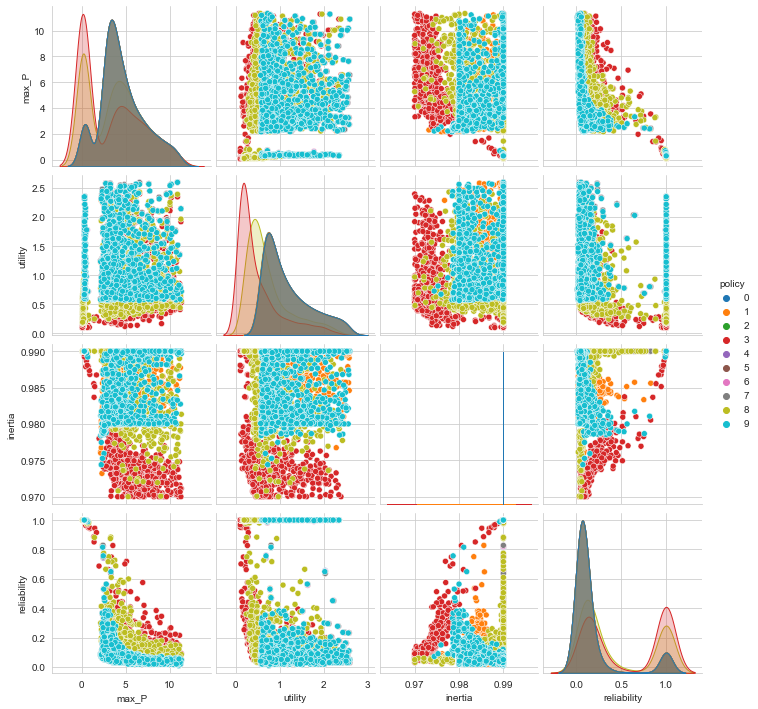

In [6]:
sns.pairplot(data, hue="policy", vars=list(outcomes.keys()))
plt.show()